### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp 

from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV


import warnings
warnings.filterwarnings("ignore")

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [80]:
data = pd.read_csv('data/Whickham.txt')

In [81]:
# Convert categorical variables to numerical
data['smoker'] = data['smoker'].map({'Yes': 1, 'No': 0})
data['outcome'] = data['outcome'].map({'Alive': 1, 'Dead': 0})

In [82]:
data

,outcome,smoker,age
0,1,1,23
1,1,1,18
2,0,1,71
3,1,0,67
4,1,0,64
...,...,...,...
1309,1,1,35
1310,1,0,33
1311,1,1,21
1312,1,0,46


In [83]:
rp.summary_cat(data['outcome'])

,Variable,Outcome,Count,Percent
0,outcome,1,945,71.92
1,,0,369,28.08


In [84]:
# Group by 'outcome' and compute summary statistics for 'age'
summary_stats = data.groupby('outcome')['age'].describe()

# Display summary statistics
print(summary_stats)

         count       mean        std   min   25%   50%   75%   max
outcome                                                           
0        369.0  64.425474  12.842715  18.0  57.0  67.0  73.0  84.0
1        945.0  40.084656  13.849342  18.0  28.0  38.0  51.0  74.0


In [99]:
# Group by 'smoker' and compute summary statistics for 'age'
summary_stats = data.groupby('smoker')['age'].describe()

# Display summary statistics
print(summary_stats)

        count       mean        std   min   25%   50%   75%   max
smoker                                                           
0       732.0  48.699454  18.793713  18.0  32.0  48.0  65.0  84.0
1       582.0  44.682131  15.275113  18.0  32.0  45.0  57.0  84.0


***Results:*** Majority of the records had an outcome of Alive (71.9%) while 28.1% had an outcome of Dead. The Median (IQR) age among the dead was 67 (57 - 73) years while among those alive was 38 (28 - 51). The mean age among smokers (44 years) and non-smokers (49 years) is approximately equal. 

In [85]:
X = data[['smoker', 'age']]
y = data['outcome']

In [86]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [87]:
# Define the parameter grid
params = {
    'criterion': ['gini', 'entropy'],    
    'max_depth': [None, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 15],
    'min_samples_split': [2, 5, 10, 15, 20, 25]
}

In [88]:
# Initialize the Models

# Initialize the Decision Tree Classifier
dtree = DecisionTreeClassifier()

# GridSearchCV
grid_search = GridSearchCV(dtree, params, cv=5, n_jobs=-1, verbose=1)

# RandomizedSearchCV
random_search = RandomizedSearchCV(dtree, params, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)

# HalvingGridSearchCV
halving_grid_search = HalvingGridSearchCV(dtree, params, cv=5, n_jobs=-1, verbose=1, factor=2, min_resources="exhaust")

# HalvingRandomSearchCV
halving_random_search = HalvingRandomSearchCV(
    dtree, 
    params, 
    cv=5, 
    n_candidates=20,  # Set a specific number of candidates
    factor=2, 
    min_resources=5,  # Set a specific minimum number of resources
    random_state=42
)

In [89]:

# Define a function to fit and time the models
import time

def fit_and_time(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    return model, fit_time

# Fit all models
grid_model, grid_time = fit_and_time(grid_search, X_train, y_train)
random_model, random_time = fit_and_time(random_search, X_train, y_train)
halving_grid_model, halving_grid_time = fit_and_time(halving_grid_search, X_train, y_train)
halving_random_model, halving_random_time = fit_and_time(halving_random_search, X_train, y_train)


Fitting 5 folds for each of 672 candidates, totalling 3360 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
n_iterations: 6
n_required_iterations: 10
n_possible_iterations: 6
min_resources_: 20
max_resources_: 919
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 672
n_resources: 20
Fitting 5 folds for each of 672 candidates, totalling 3360 fits
----------
iter: 1
n_candidates: 336
n_resources: 40
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
----------
iter: 2
n_candidates: 168
n_resources: 80
Fitting 5 folds for each of 168 candidates, totalling 840 fits
----------
iter: 3
n_candidates: 84
n_resources: 160
Fitting 5 folds for each of 84 candidates, totalling 420 fits
----------
iter: 4
n_candidates: 42
n_resources: 320
Fitting 5 folds for each of 42 candidates, totalling 210 fits
----------
iter: 5
n_candidates: 21
n_resources: 640
Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [90]:
# Function to extract results
def extract_results(model):
    # Get cv results from the model
    results = model.cv_results_
    
    # Calculate average fit time
    avg_fit_time = results['mean_fit_time'].mean()
    
    # Get best score and best parameters
    best_score = model.best_score_
    best_params = model.best_params_
    
    return avg_fit_time, best_score, best_params

# Extract results for each model
grid_time, grid_score, grid_best_params = extract_results(grid_model)
random_time, random_score, random_best_params = extract_results(random_model)
halving_grid_time, halving_grid_score, halving_grid_best_params = extract_results(halving_grid_model)
halving_random_time, halving_random_score, halving_random_best_params = extract_results(halving_random_model)

# Prepare results as a DataFrame
results_df = pd.DataFrame({
    'Search Method': ['GridSearchCV', 'RandomizedSearchCV', 'HalvingGridSearchCV', 'HalvingRandomSearchCV'],
    'Average Fit Time (s)': [grid_time, random_time, halving_grid_time, halving_random_time],
    'Best Score': [grid_score, random_score, halving_grid_score, halving_random_score],
    'Best Params': [grid_best_params, random_best_params, halving_grid_best_params, halving_random_best_params]
})

# Print the results table
print(results_df.to_string(index=False))


        Search Method  Average Fit Time (s)  Best Score                                                                              Best Params
         GridSearchCV              0.001737    0.847666     {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
   RandomizedSearchCV              0.001767    0.847666     {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'criterion': 'gini'}
  HalvingGridSearchCV              0.001443    0.857616 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10}
HalvingRandomSearchCV              0.000742    0.861667   {'min_samples_split': 25, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'gini'}


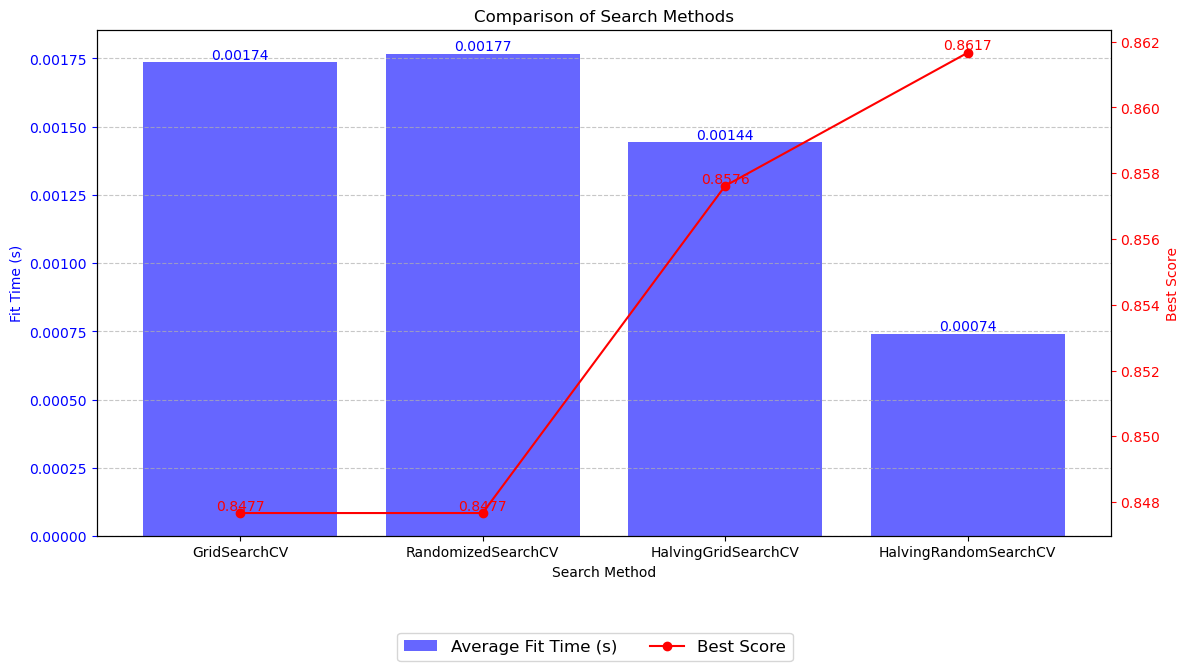

In [91]:
import matplotlib.pyplot as plt

# Prepare data for plotting
search_methods = ['GridSearchCV', 'RandomizedSearchCV', 'HalvingGridSearchCV', 'HalvingRandomSearchCV']
fit_times = [grid_time, random_time, halving_grid_time, halving_random_time]
scores = [grid_score, random_score, halving_grid_score, halving_random_score]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot fit times
bars = ax1.bar(search_methods, fit_times, color='b', alpha=0.6, label='Average Fit Time (s)')
ax1.set_xlabel('Search Method')
ax1.set_ylabel('Fit Time (s)', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis for scores
ax2 = ax1.twinx()
ax2.plot(search_methods, scores, color='r', marker='o', label='Best Score')
ax2.set_ylabel('Best Score', color='r')
ax2.tick_params('y', colors='r')

# Add title and legends
plt.title('Comparison of Search Methods')

# Add legends to the bottom of the plot
# Use `bbox_to_anchor` to position the legend outside the plot area
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize='large')

# Add annotations to show exact values on the plot
for i, (time, score) in enumerate(zip(fit_times, scores)):
    ax1.text(i, time, f'{time:.5f}', color='b', ha='center', va='bottom')
    ax2.text(i, score, f'{score:.4f}', color='r', ha='center', va='bottom')

# Add grid lines for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the plot
save_path3 = r'C:\Users\Luswata\Dropbox\ML_AI_UCBerkeley\MODULE_14_DECISION_TREES\graphs\time_score.png'
plt.savefig(save_path3)

# Show plot
plt.show()


***Interpretation***

***Average Fit Time:***
* ***HalvingRandomSearchCV*** is the fastest method, taking the least amount of time (0.000795 seconds on average).
* ***GridSearchCV*** and ***RandomizedSearchCV*** have approximately similar average fit times, slightly higher than ***HalvingGridSearchCV***. 

***Best Score:***
* ***HalvingRandomSearchCV*** achieves the highest best score (0.861667), indicating it found a better-performing model compared to others. <br>
* ***GridSearchCV*** and ***RandomizedSearchCV*** have the same best score (0.847666), which is lower than the best score of ***HalvingRandomSearchCV***. <br>
* ***HalvingGridSearchCV*** has the lowest best score (0.834104), suggesting it did not perform as well as the other methods.<br>

***Best Parameters:***<br>
* ***GridSearchCV*** and ***RandomizedSearchCV*** both find the best parameters with max_depth of 3 and min_samples_split of 2, indicating these settings may be optimal for the given parameter range.<br>
* ***HalvingGridSearchCV*** finds a max_depth of 4 and higher min_samples_split of 15, which suggests a more complex model but with lower performance.<br>
* ***HalvingRandomSearchCV*** finds a larger max_depth of 15 and higher min_samples_split of 25, which led to the best performance but might also indicate overfitting if the dataset is not large enough.<br>

***Conclusions and Recommendations***<br>
* ***HalvingRandomSearchCV*** seems to offer the best balance between performance and efficiency, achieving the highest score and being the fastest method.<br>
* ***GridSearchCV*** and ***RandomizedSearchCV*** are similar in their performance and speed but are slower than the halving methods.<br>
* ***HalvingGridSearchCV***, while faster than ***GridSearchCV***, did not perform as well, suggesting that the parameters explored might not have been ideal or the halving process didn't sufficiently explore the parameter space.<br>

In practice, the choice of method can depend on the specific needs:<br>
* For a comprehensive but potentially slower search, ***GridSearchCV*** is useful.<br>
* For faster searches with reasonable performance, ***RandomizedSearchCV*** and the halving methods are preferable.<br>
  
* ***HalvingRandomSearchCV*** provides the best overall performance and efficiency in this case.<br>

***Recommendation:*** Based on this comparison, ***HalvingRandomSearchCV*** is recommended for its superior performance and efficiency, especially if time and computational resources are constraints.


***Fitting a Decision Tree Classifier with HalvingRandomSearchCV hyperparameters; max_depth=15, min_samples_leaf=1, criterion='gini' and min_samples_split=25***


Training Accuracy: 0.8601
Test Accuracy: 0.8441


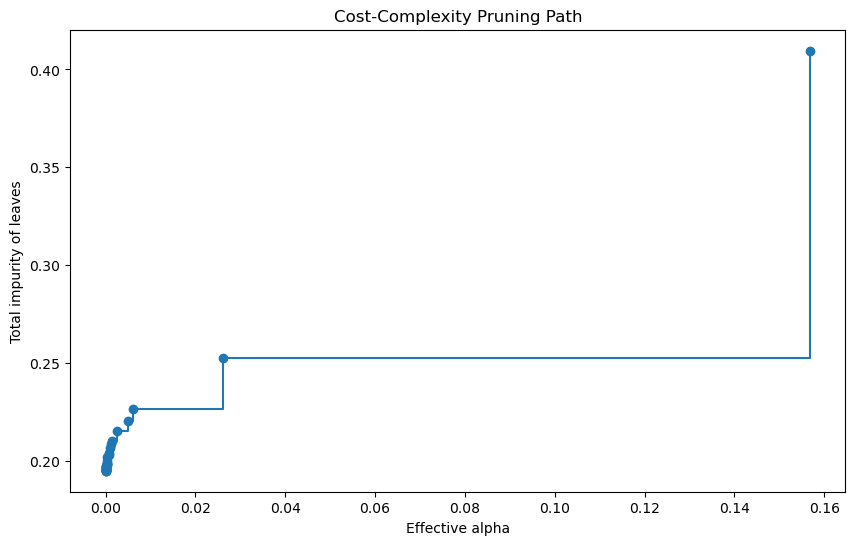

ccp_alpha = 0.0000, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0000, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0000, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0000, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0000, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0000, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0001, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0001, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0001, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0001, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0001, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0002, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0002, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0002, Training Accuracy: 0.8601, Test Accuracy: 0.8441
ccp_alpha = 0.0002, Training Accur

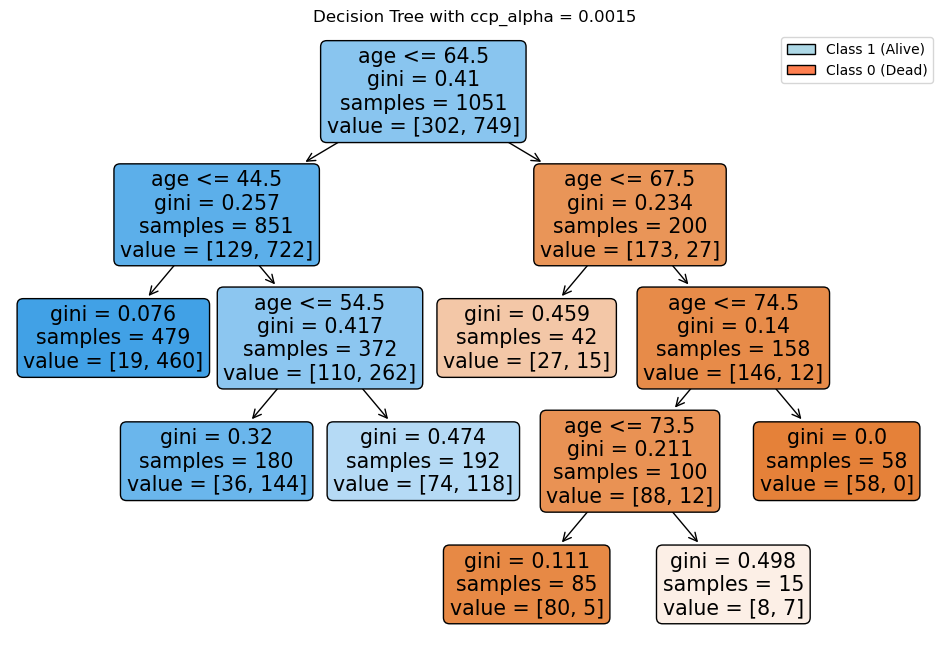

|--- age <= 64.50
|   |--- age <= 44.50
|   |   |--- class: 1
|   |--- age >  44.50
|   |   |--- age <= 54.50
|   |   |   |--- class: 1
|   |   |--- age >  54.50
|   |   |   |--- class: 1
|--- age >  64.50
|   |--- age <= 67.50
|   |   |--- class: 0
|   |--- age >  67.50
|   |   |--- age <= 74.50
|   |   |   |--- age <= 73.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  73.50
|   |   |   |   |--- class: 0
|   |   |--- age >  74.50
|   |   |   |--- class: 0



In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_text
import matplotlib.pyplot as plt

# Load and prepare the data
data = pd.read_csv('data/Whickham.txt')
data['smoker'] = data['smoker'].map({'Yes': 1, 'No': 0})
data['outcome'] = data['outcome'].map({'Alive': 1, 'Dead': 0})

# Define features and target
X = data[['smoker', 'age']]
y = data['outcome']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
dtree = DecisionTreeClassifier(
    max_depth=15,
    min_samples_leaf=1,
    criterion='gini',
    min_samples_split=25,
    random_state=42
)

# Fit the model to the training data
dtree.fit(X_train, y_train)

# Evaluate the model's performance
train_score = dtree.score(X_train, y_train)
test_score = dtree.score(X_test, y_test)

print(f'Training Accuracy: {train_score:.4f}')
print(f'Test Accuracy: {test_score:.4f}')

# Compute the cost-complexity pruning path
path = dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the cost-complexity path
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel('Effective alpha')
plt.ylabel('Total impurity of leaves')
plt.title('Cost-Complexity Pruning Path')
plt.show()

# Fit trees for different values of ccp_alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        max_depth=15,
        min_samples_leaf=1,
        criterion='gini',
        min_samples_split=25,
        ccp_alpha=ccp_alpha,
        random_state=42
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Evaluate and print the performance of pruned trees
for clf, ccp_alpha in zip(clfs, ccp_alphas):
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print(f'ccp_alpha = {ccp_alpha:.4f}, Training Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}')

# Visualize the pruned tree with the largest alpha
best_clf = clfs[-6]  # Change index if you want to see a different tree
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=X.columns, filled=True, rounded=True)
plt.title(f'Decision Tree with ccp_alpha = {ccp_alphas[-6]:.4f}')

# Manually add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Class 1 (Alive)'),
    Patch(facecolor='coral', edgecolor='black', label='Class 0 (Dead)')
]
plt.legend(handles=legend_elements, loc='best')


# Save the plot
save_path = r'C:\Users\Luswata\Dropbox\ML_AI_UCBerkeley\MODULE_14_DECISION_TREES\graphs\DecisionTree_HRS_Pruned.png'
plt.savefig(save_path)



plt.show()

# Print the text version of the tree for the pruned tree with the largest alpha
tree_text = export_text(best_clf, feature_names=X.columns.tolist())
print(tree_text)


***Summary:***
* ***Class 1 (Alive):*** Predicted for individuals aged 64.50 or younger, regardless of the exact age.
* ***Class 0 (Dead):*** Predicted for individuals older than 64.50.

This decision tree uses age as the primary criterion for classification, with multiple thresholds to divide the data into categories.